# Data download and exploratory analysis

Currently precipitation radar nowcasting is mainly done by optical flow or radial velocity estimates. If we use neural nets we can maybe capture the behavior of rain clouds better (e.g. a single summer evening cumulonimbus versus a heat front), and the topographic influences (e.g. fohn effect), without explicitly specifying rules or terrain.

## Relevant papers

It's already being done here: http://arxiv.org/pdf/1506.04214.pdf

## Data

The KNMI has an [open data program](http://data.knmi.nl) now. I identified three interesting datasets:

- [2008-] [5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_tar_refl_composites/1.0), this is what we're trying to establish the behavior of, and what should be our internal state.
- [2008-] [Forecasted 5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_forecast/1.0), this is our baseline, where they extrapolate the radar images based on a velocity estimate. Only the data of last day is online, which is a pity. Might contact them to get my hands on more data.
- [2008-] [5-min gauge-adjusted precipitation accumulations (1 km, extended mask)](http://data.knmi.nl/datasets/rad_nl25_rac_mfbs_em_5min/2.0), this can serve as the ground truth. Would be amazing if we can train with radar reflectivity as input and this as output, then the errors in the reflectivity composites might be diminished.
- [2014-] [Radar echo top height composites](http://data.knmi.nl/datasets/radar_tar_echotopheight_5min/1.0), I'm not keen on training on the full radar reflectivity volumes, but this might just be a nice derivative that does give extra information that might add to the model's predictive power.

Most of this data is available via FTP. The format, projection and extent is described at http://adaguc.knmi.nl/contents/datasets/productdescriptions/W_ADAGUC_Product_description_RADNL_OPER_R___25PCPRR_L3.html.

## Dependencies

`conda install h5py tqdm matplotlib pyproj`

Use SIMD-accelerated pillow for faster resizing:
`CC="cc -mavx2" pip install -U --force-reinstall pillow-simd`

In [1]:
# All imports
import os, io, re, glob, tarfile
import concurrent.futures
from pprint import pprint

# Third parties
import h5py
import numpy as np
from IPython.display import Image
from ftplib import FTP
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tarfile

# Own code
import utils

# Constants
folder = utils.RADAR_REFL_COMP_DIR

%matplotlib inline
%load_ext autoreload

### File discovery

The radar reflectivity composites are organized in *.tar* files, one per day. Let's retrieve all their filenames. (This can take a while for something like 10\*365 filenames.)

In [2]:
## Ok, now on to the real stuff: radar reflectivity composites
refl_comp_ftp_urls = []

with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    yearfolders = ftp.nlst('/download/radar_tar_refl_composites/1.0/0001/')
    for yearfolder in yearfolders:
        for monthfolder in ftp.nlst(yearfolder):
            for dayfolder in ftp.nlst(monthfolder):
                # Should contain just one file
                for day_file in ftp.nlst(dayfolder):
                    refl_comp_ftp_urls.append(day_file)
                    # Use carriage return to overwrite
                    print("Retrieve filename # {}".format(len(refl_comp_ftp_urls)), end='\r')

print("Finished")

# Save to file for later retrieval
with open('refl_comp_ftp_urls.txt', 'w') as f:
    f.write('\n'.join(refl_comp_ftp_urls))

230 login accepted


Run the cell below to restore urls from file.

In [75]:
# Run this to restore from file
with open('refl_comp_ftp_urls.txt', 'r') as f:
    # Clean up \n's
    refl_comp_ftp_urls = [l.strip() for l in f.readlines()]
print("Loaded {} filenames".format(len(refl_comp_ftp_urls)))

Loaded 3602 filenames


### Downloading files

Now we download all files. You probably want to download a smaller subset at first because this can take hours (it's >75GB and their ftp server is not so fast).

In [ ]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    for ftp_url in tqdm_notebook(refl_comp_ftp_urls, desc="Downloading files", unit="file"):
        utils.download_cache_ftp(utils.RADAR_REFL_COMP_DIR, ftp, ftp_url, verbose=False)

Next step is to untar all the files. I'd like to do that in streaming fashion but the h5py library doesn't support that in an easy way.

So now we untar to disk, taking care to check if the files exist and then deleting the original file to save space. The code is slightly more verbose because of the 

In [4]:
tar_files = sorted(glob.glob(os.path.join(folder, '*.tar')))

print("Found {} tar files in {}".format(len(tar_files), folder))

def untar_file(tfp):
    t = tarfile.open(tfp)
    try:
        contents_list = t.getnames()
        t.extractall(folder)
    except tarfile.ReadError as e:
        print("Failed to read file {}".format(tfp))
        raise e
    # Check if files exist
    for f in contents_list:
        path = os.path.join(folder, f)
        if not os.path.isfile(os.path.join(path)):
            raise Warning("%s not found!", path)
    # Remove original file to avoid doubling disk space
    os.remove(tfp)

# Untar concurrently for massive speedup
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as e:
    tasks = [e.submit(untar_file, tfp) for tfp in tar_files]
    print("Submitted all tasks")
    # Wait for finish and show progress bar
    for future in tqdm_notebook(concurrent.futures.as_completed(tasks), desc="Extracting", unit="file"):
        # Retrieve exceptions
        # NOTE: These are raised after all futures have completed!
        # tqdm progress bar will stop working 
        future.result()


Found 0 tar files in /home/ubuntu/nowcasting-convrnn/data/radar_refl_comp
Submitted all tasks


A Jupyter Widget

In [28]:
## Construct dataset obj compliant with torch abstractions

class ReflCompTarDataset():
    def __init__(self, folder):
        "Search folder for hdf5 files and add them to dataset"
        # Sort by filename, which reflects date
        self.h5files = sorted(glob.glob(os.path.join(folder, '*.h5')))
    
    def show_structure(self, idx):
        "Returns list of lines"
        out = []
        self.__getitem__(idx).visititems(lambda name, obj: out.append('{}\n\t{}'.format(name,obj)))
        return out
    
    def __getitem__(self, idx):
        return h5py.File(self.h5files[idx])

ds = ReflCompTarDataset(folder)
print("File 20 contains:")
print('\n'.join(ds.show_structure(20)))

File 20 contains:
geographic
	<HDF5 group "/geographic" (1 members)>
geographic/map_projection
	<HDF5 group "/geographic/map_projection" (0 members)>
image1
	<HDF5 group "/image1" (3 members)>
image1/calibration
	<HDF5 group "/image1/calibration" (0 members)>
image1/image_data
	<HDF5 dataset "image_data": shape (765, 700), type "|u1">
image1/statistics
	<HDF5 group "/image1/statistics" (0 members)>
overview
	<HDF5 group "/overview" (0 members)>
radar1
	<HDF5 group "/radar1" (0 members)>
radar2
	<HDF5 group "/radar2" (0 members)>
visualisation1
	<HDF5 group "/visualisation1" (1 members)>
visualisation1/color_palette
	<HDF5 dataset "color_palette": shape (256, 3), type "|u1">


In [7]:
'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'
# 0.0, 49.36206, 0.0, 55.973602, 10.856429, 55.388973, 9.00928, 48.8953
bbox = np.array([[  0.      ,  49.36206 ],
                 [  0.      ,  55.973602],
                 [ 10.856429,  55.388973],
                 [  9.00928 ,  48.8953  ]])

In [8]:
bbox_stere = stere_nl.transform_points(ccrs.PlateCarree(), bbox.T[0], bbox.T[1])[:,:2]
bbox_stere

array([[       0.        , -4414999.26925175],
       [       0.        , -3649995.342279  ],
       [  700000.19193933, -3649995.61044838],
       [  700000.28568481, -4414999.63551544]])

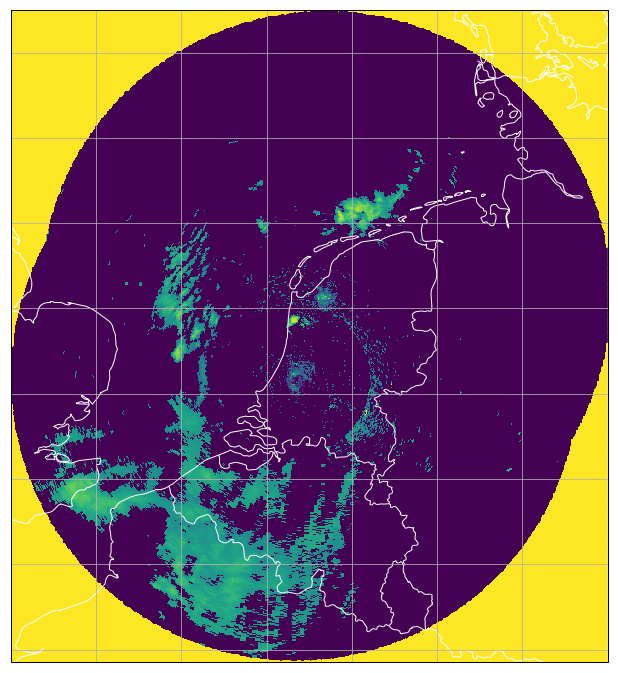

In [93]:
from matplotlib import animation, rc
from IPython.display import HTML

#!conda install -c conda-forge cartopy
import cartopy.crs as ccrs
import cartopy.feature

stere_nl = ccrs.Stereographic(central_latitude=90, true_scale_latitude=60)
stere_nl.proj4_params

proj_pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,12))

ax = plt.axes(projection=stere_nl)

ext = (bbox[:,0].min(), bbox[:,0].max(), bbox[:,1].min(), bbox[:,1].max())

ext_stere = (0, 700000, -4415000, -3650000)

ax.set_extent(ext_stere, crs=stere_nl)

# We need one extra, not sure why
lons = np.linspace(ext_stere[0], ext_stere[1], 701)
lats = np.linspace(ext_stere[2], ext_stere[3], 766)

cmesh = ax.pcolormesh(lons, lats, np.array(ds[0]['image1']['image_data']), vmin=0, vmax=120)

def animate(i):
    arr = np.array(ds[i*12]['image1']['image_data'])
#     cmesh = ax.pcolormesh(lons, lats, arr)
    cmesh.set_array(arr.ravel())
    return cmesh.findobj()

# Add high-res coastline
ax.coastlines('10m', color='white')
# Add high-res border
ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m'),
               edgecolor='white', facecolor='none')
ax.gridlines(crs=stere_nl)
# plt.show()



anim = animation.FuncAnimation(fig, animate,
                               frames=3, interval=200, blit=True)

# Nice slice would be radar[250:550,200:500]

HTML(anim.to_html5_video())